In [1]:
import imageio as img
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy import signal
from scipy import ndimage
import matplotlib


(1195, 1857, 4)
(1195, 1857)


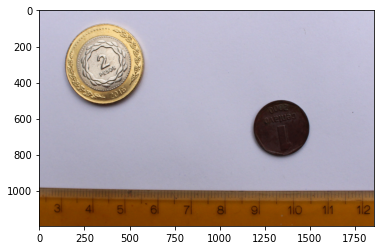

In [2]:
#matplotlib.use('Qt5Agg')

im = img.imread('vil_metal.png')

#Mostrar imagen original
print(im.shape)
print(im[:,:,0].shape)
plt.imshow(im)
plt.show()

In [3]:
#función para plotear más rápido:

def plotear_con_coord(im, punto=None):
    plt.imshow(im)
    xlen = im.shape[1]
    ylen = im.shape[0]
    if punto:
        xpunto = punto[0]
        ypunto = punto[1]
        plt.plot([0,xlen],[ypunto,ypunto])
        plt.plot([xpunto,xpunto], [0,ylen])
    plt.xlim([0,xlen])
    plt.ylim([ylen,0])
    plt.show()
    return 

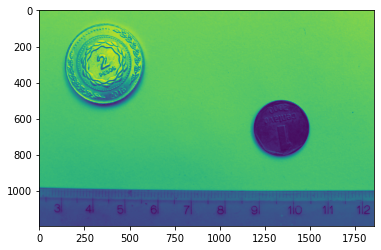

In [4]:
#Definir la matriz que hará la convolución
kernel = [[1,2,1],[0,0,0],[-1,-2,-1]]

#componente verde de la imagen convolucionada (detección de bordes horizontal)
H = signal.convolve2d(im[:,:,1], kernel)


#Mostrar componente verde de la imagen
plt.imshow(im[:,:,1])
plt.show()

(1197, 1859)


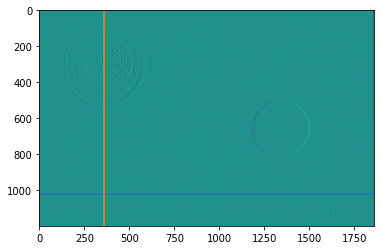

In [5]:
#componente verde de la imagen convolucionada (detección de bordes vertical)
V = signal.convolve2d(im[:,:,1], np.transpose(kernel))

print(V.shape)

#Mostrar imagen con detección de bordes vertical y dos rectas, una horizontal y otra vertical
#La intersección de las rectas muestra alrededor de qué puntos de la regla voy a calibrar

posicion_de_calibracion_y = 1022
posicion_de_calibracion_x = 360
plotear_con_coord(V, punto=[posicion_de_calibracion_x, posicion_de_calibracion_y])


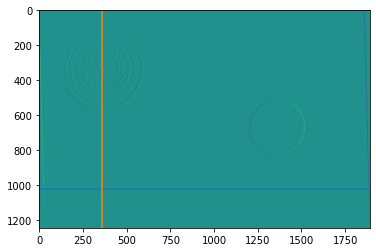

In [6]:
#Se ve que las lineas de la regla no estan perfectamente alineadas con la recta vertical
#Rotar la imagen en el ángulo necesario:
angulo = 1.5
V_rotada = ndimage.rotate(V, angulo)
plotear_con_coord(V_rotada, punto=[posicion_de_calibracion_x, posicion_de_calibracion_y])

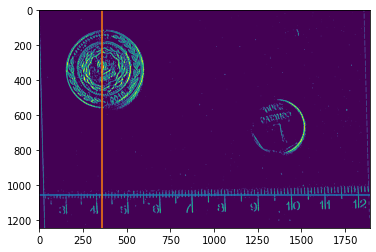

In [7]:
#Creamos imagen binarizada y modifico la posición de la recta horizontal:
modificacion = 35
posicion_de_calibracion_y = posicion_de_calibracion_y + modificacion
im_bin = np.zeros(V_rotada.shape)
filtro = (V_rotada > 25)
im_bin[filtro] = 1

#Mostramos imagen binarizada más el rango del plot que vamos a utilizar para calibrar
plotear_con_coord(im_bin, punto=[posicion_de_calibracion_x, posicion_de_calibracion_y])

Len puntos:  18
17.651852591630885 ± 3.1113957030956034


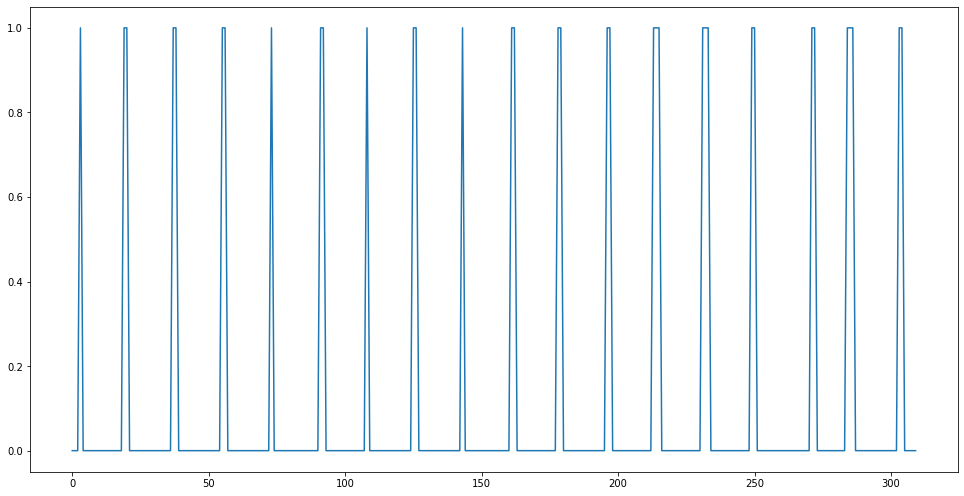

In [8]:
matplotlib.use('Qt5Agg')

#Hacemos un ploteo de los valores de la imagen para la recta horizontal entre los valores de x
#tales que la rotación siga valiendo. Además extraemos los puntos necesarios del plot.
#Todos los puntos se seleccionan a mano y precisamente (método 1):
vals_a_yfijo = im_bin[posicion_de_calibracion_y, 220:530]
plt.plot(vals_a_yfijo)
puntos = plt.ginput(18, timeout=60)
print("Len puntos: ",len(puntos))
puntos = np.array(puntos)
puntos_x = puntos[:,0]

#Calculamos el promedio de distancia entre los puntos y la desviación estandar
#correspondiente, con eso definimos una escala pixel/mm para así medir las distancias.
diff = np.diff(puntos_x)
escala = np.mean(diff)
escala_error = np.std(diff)
print(escala, "±", 2*escala_error)


Len puntos2:  18
17.663937580446117


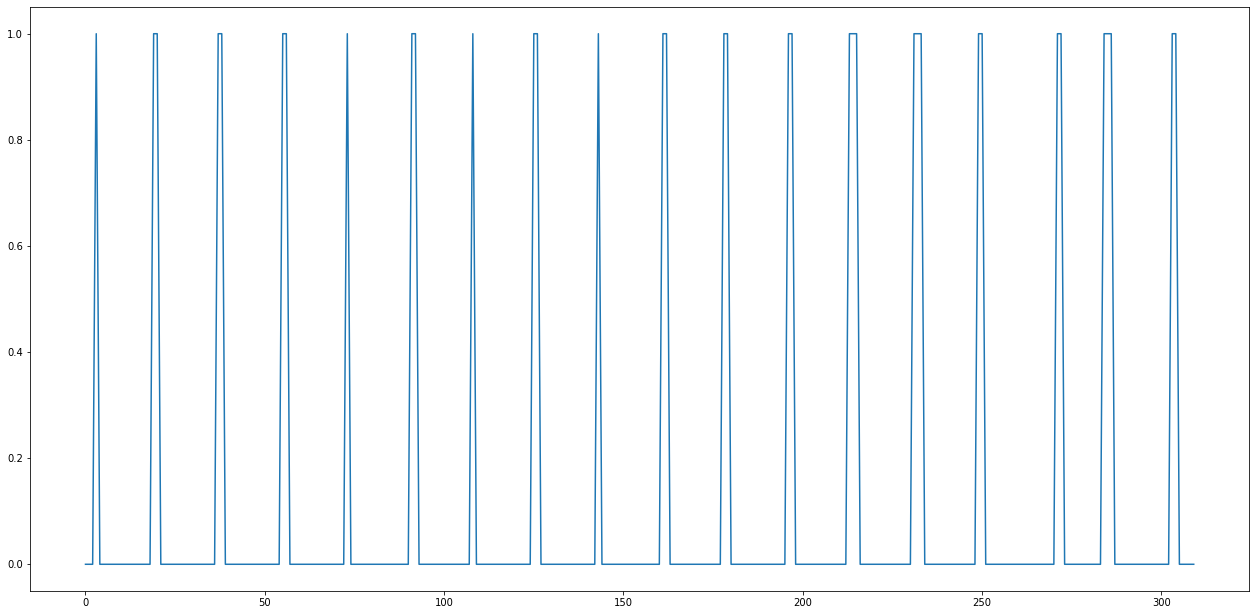

In [10]:
#Voy a hacer lo mismo perocon otro método. Se cuentan todos los puntos a manos pero sólo es 
#necesario tomar precisamente el primero y el último:
vals_a_yfijo = im_bin[posicion_de_calibracion_y, 220:530]
plt.plot(vals_a_yfijo)
puntos2 = plt.ginput(18, timeout=60)
print("Len puntos2: ",len(puntos2))
puntos2 = np.array(puntos2)
puntos2_x = puntos2[:,0]

#Calculamos el promedio de distancia entre el punto inicial y el final, luego dividimos por
#la cantidad de puntos para obtener una distancia promedio.
#¿Cómo calculo el error de esto?
diff2 = puntos2_x[-1] - puntos2_x[0]
escala2 = diff2/(len(puntos2_x)-1)
#escala_error = np.std(diff)??
print(escala2) #, "±", escala_error)

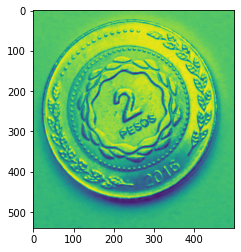

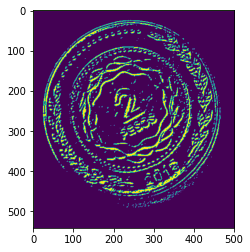

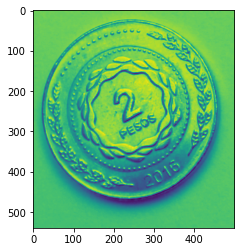

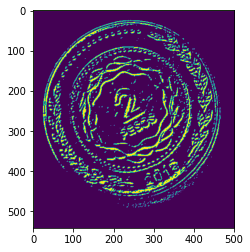

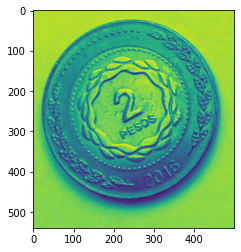

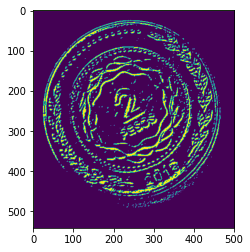

In [20]:
mon_2 = ndimage.rotate(im,angulo)[90:630,130:630]
%matplotlib inline
#mon_2 = mon_2/255
#mon_2 = mon_2*np.log(mon_2)

for i, color in enumerate(["red","green","blue"]):
    plt.imshow(mon_2[:,:,i], label=color)
    plt.show()
    filtro = (mon_2_bor > 70)
    mon_2_bin = np.zeros(mon_2_bor.shape)
    mon_2_bin[filtro] = 1
    plt.imshow(mon_2_bin)
    plt.show()
    pass

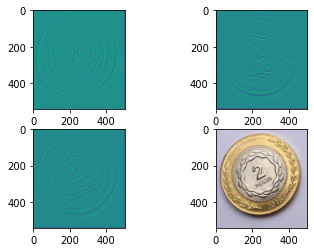

In [12]:
#hago un poco de procesamiento sobre la imagen de la moneda para identificar mejor los bordes:
mon_2 = ndimage.rotate(im,angulo)[90:630,130:630]
mon_2_verde = mon_2[:,:,1]
mon_2_vert = signal.convolve2d(mon_2_verde, np.transpose(kernel))
mon_2_hor = signal.convolve2d(mon_2_verde, kernel)
mon_2_bor = mon_2_vert + mon_2_hor

#matplotlib.use('Qt5Agg')
fig, axs = plt.subplots(2,2)
axs[0][0].imshow(mon_2_vert)
axs[0][1].imshow(mon_2_hor)
axs[1][0].imshow(mon_2_bor)
axs[1][1].imshow(mon_2)



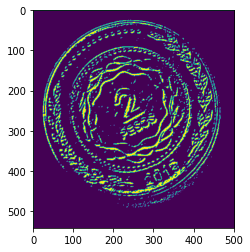

In [13]:
filtro = (mon_2_bor > 70)
mon_2_bin = np.zeros(mon_2_bor.shape)
mon_2_bin[filtro] = 1

plotear_con_coord(mon_2_bin)

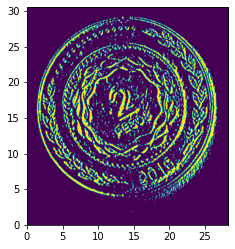

In [16]:
#ahora normalizamos el gráfico. pero lo voy a hacer para la región cercana a donde calibré:
moneda_de_2 = im_bin[90:630,130:630]
eje_x2 = np.arange(moneda_de_2.shape[1])/escala2
eje_y2 = np.arange(moneda_de_2.shape[0])/escala2

plt.imshow(moneda_de_2, extent=[eje_x2.min(), eje_x2.max(), eje_y2.min(), eje_y2.max()])
plt.show()

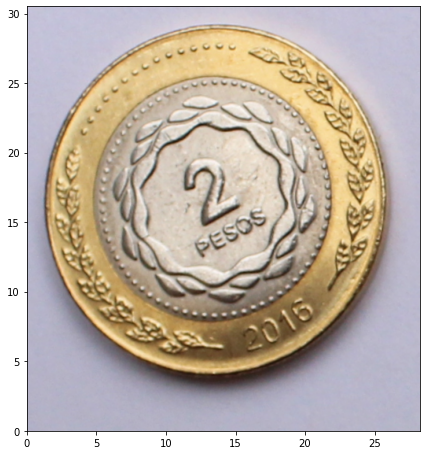

In [17]:
#mejor elijo los bordes desde la foto original:
matplotlib.use("Qt5Agg")
plt.imshow(mon_2, extent=[eje_x2.min(), eje_x2.max(), eje_y2.min(), eje_y2.max()])
extremos_moneda = plt.ginput(4, timeout=60)
arriba, abajo, izquierda, derecha = extremos_moneda
plt.show()

In [19]:
print("distancia tomada a mano vertical:",derecha[0]-izquierda[0], "\ndistancia tomada a mano horizontal:", arriba[1]-abajo[1])

distancia tomada a mano vertical: 24.66675933964416 
distancia tomada a mano horizontal: 25.38590684225769


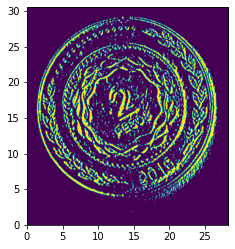

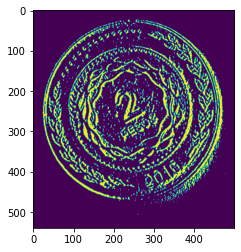

In [21]:
%matplotlib inline
moneda_de_2 = im_bin[90:630,130:630]
eje_x2 = np.arange(moneda_de_2.shape[1])/escala2
eje_y2 = np.arange(moneda_de_2.shape[0])/escala2

plt.imshow(moneda_de_2, extent=[eje_x2.min(), eje_x2.max(), eje_y2.min(), eje_y2.max()])
plt.show()
plt.imshow(moneda_de_2)
plt.show()

In [40]:
#Defino una función para tomar las coordenadas de los puntos del borde que están bien definidos
def tomar_borde(imagen, inicio=[0,0],fin=[-1, -1] , direccion=True):
    puntos = []
    in_y = inicio[1]
    in_x = inicio[0]
    fin_x = fin[0]
    fin_y = fin[1]
    
    if direccion:
        while in_x <= fin_x:
            punto_y = in_y
            pix = imagen[in_y, in_x]
            while not pix:
                punto_y = punto_y - 1
                pix = imagen[punto_y, in_x]
            puntos.append([in_x, punto_y])
            in_x += 1
    else:
        while in_x <= fin_x:
            punto_y = in_y
            pix = imagen[in_y, in_x]
            while not pix:
                punto_y = punto_y + 1
                pix = imagen[punto_y, in_x]
            puntos.append([in_x, punto_y])
            in_x += 1
    return puntos
    
    

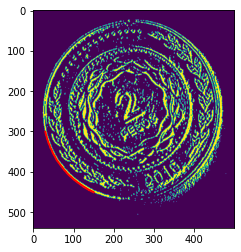

In [43]:
borde = tomar_borde(moneda_de_2, inicio=[30,500],fin=[150,500])
borde = np.array(borde)
borde_x = borde[:,0]
borde_y = borde[:,1]
plt.plot(borde_x, borde_y, linewidth=2, color="red")
plt.imshow(moneda_de_2)
plt.show()



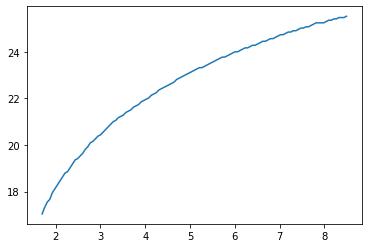

In [44]:
borde_mm = borde/escala2
bordex_mm = borde_mm[:,0]
bordey_mm = borde_mm[:,1]
plt.plot(bordex_mm, bordey_mm)

In [52]:
#metodo para sacar el radio y el centro de un circulo sacado de 
#https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html

from scipy import linalg

x = bordex_mm
y = bordey_mm

# coordinates of the barycenter
x_m = np.mean(x)
y_m = np.mean(x)

# calculation of the reduced coordinates
u = x - x_m
v = y - y_m

# linear system defining the center (uc, vc) in reduced coordinates:
#    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
#    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
Suv  = np.sum(u*v)
Suu  = np.sum(u**2)
Svv  = np.sum(v**2)
Suuv = np.sum(u**2 * v)
Suvv = np.sum(u * v**2)
Suuu = np.sum(u**3)
Svvv = np.sum(v**3)

# Solving the linear system
A = np.array([ [ Suu, Suv ], [Suv, Svv]])
B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
uc, vc = linalg.solve(A, B)

xc_1 = x_m + uc
yc_1 = y_m + vc

# Calcul des distances au centre (xc_1, yc_1)
Ri_1     = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
R_1      = np.mean(Ri_1)
residu_1 = np.sum((Ri_1-R_1)**2)

print("centro en x:",xc_1, "\ncentro en y:",yc_1, "\nradio:", R_1, "±", residu_1, "\ndiametro:", 2*R_1, "±", 2*residu_1)

centro en x: 13.984942471544128 
centro en y: 14.132001569011269 
radio: 12.676014971496814 ± 0.056645685392501074 
diametro: 25.352029942993628 ± 0.11329137078500215


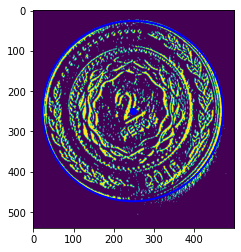

In [60]:
#Grafico la moneda y su centro 
fig, ax = plt.subplots(1)
ax.plot(xc_1*escala2, yc_1*escala2, 'bo')
ax.imshow(moneda_de_2)
ax.add_patch(plt.Circle((xc_1*escala2, yc_1*escala2), R_1*escala2, fc="none", color="blue", linewidth=2))
plt.show()